# Modeling: Multilingual-BERT For Sentiment Analysis
Fine-tuning an M-BERT model for ISP Sentiment Prediction

**`Goal:`**

### 1. Library Importation

In [2]:
#Visualization packages
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

#Modeling and evaluation packages
import torch
from transformers import BertForSequenceClassification, BertTokenizer, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support,classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_splitr

### 2. Loading the data

In [3]:
df = pd.read_csv('../data/processed/sample_encoded_and_cleaned.csv')

In [4]:
df

,ISP_Name,Time,Text,Source,sentiment,label
0,sprectranet,2020-02-04 18:30:35+00:00,my family used my spectranet and they don't wa...,Twitter for Android,Neutral,0
1,sprectranet,2019-06-19 04:59:49,spectranet_ng how can i get the freedom mifi i...,Twitter for iPhone,Negative,1
2,sprectranet,2020-03-30 07:57:38+00:00,drolufunmilayo iconic_remi spectranet_ng,Twitter for iPhone,Neutral,0
3,sprectranet,2020-12-31 21:07:52+00:00,spectranet_ng your response just proves how ho...,Twitter for Android,Negative,1
4,sprectranet,2020-09-03 23:09:09+00:00,"spectranet is just the worse tbh, i can't even...",Twitter for iPhone,Negative,1
...,...,...,...,...,...,...
373,sprectranet,2019-01-04 14:44:03,spectranet unlimited. value for money,Twitter for iPhone,Positive,2
374,sprectranet,2020-06-17 13:32:28+00:00,from 30th may to date mtn mifi - 10k spectrane...,Twitter for iPhone,Negative,1
375,sprectranet,2020-05-12 16:51:44+00:00,spectranet_ng fritzthejanitor will they help m...,Twitter for iPhone,Neutral,0
376,sprectranet,2019-02-27 18:59:31,thefunkydee spectranet_ng i'm giving spectrane...,Twitter for iPhone,Negative,1


### 3. Split data into training & test set

**Observing the true distribution of the data**

In [5]:
df.label.value_counts(normalize=True)

1    0.574074
0    0.349206
2    0.076720
Name: label, dtype: float64

Seeing as the dataset is highly imbalanced, I perform a **stratified train-test split**:

In [7]:
#Split the data 80:20 and ensure same proportion of classes as original data 
#Note: The below gets the indices of the tweets for the training and test set
X_train, X_test, y_train, y_test = train_test_split(df.index.values, 
                                                    df.label.values, 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=df.label.values)

In [8]:
#Note which tweets were split into the training and test sets so we can see the division
df.loc[X_train, 'split_group'] = 'training_set'
df.loc[X_test, 'split_group'] = 'test_set'

In [9]:
df.groupby(['sentiment', 'label', 'split_group'])[['Text']].count().sort_values('label')

Text
sentiment label split_group       
Neutral   0     test_set        26
                training_set   106
Negative  1     test_set        44
                training_set   173
Positive  2     test_set         6
                training_set    23

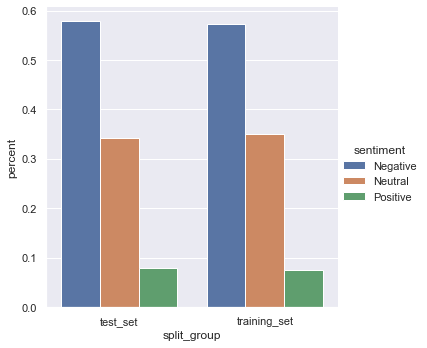

In [10]:
#Plot the proportion of each sentiment class in the training and test sets
#-to confirm the distribution is the same in both sets
sns.catplot(x='split_group', 
               y='percent', 
               hue='sentiment', 
               data=df.groupby(['split_group'])['sentiment'].value_counts(normalize=True).\
                                                                        rename('percent').\
                                                                            reset_index(),kind='bar')
plt.show()

### 4. Split training set into training set and validation set

In [11]:
#Split the training set 75:25 using stratified sampling 
#Note: The below gets the indices of the tweets for the training and validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train, 
                                                  test_size=0.25, 
                                                  random_state=1, 
                                                  stratify=y_train)

In [12]:
#Note which tweets were split into the training and validation sets so we can see the division
df.loc[X_train, 'split_group'] = 'training_set'
df.loc[X_val, 'split_group'] = 'validation_set'

In [13]:
df.groupby(['sentiment', 'label', 'split_group'])[['Text']].count().sort_values('label')

Text
sentiment label split_group         
Neutral   0     test_set          26
                training_set      79
                validation_set    27
Negative  1     test_set          44
                training_set     130
                validation_set    43
Positive  2     test_set           6
                training_set      17
                validation_set     6

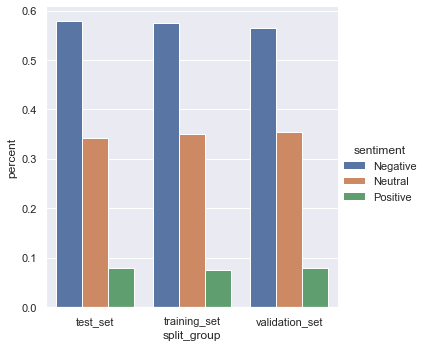

In [14]:
#Plot the proportion of each sentiment class in the training and test sets
#-to confirm the distribution is the same in both sets
sns.catplot(x='split_group', 
            y='percent', 
            hue='sentiment', 
            data=df.groupby(['split_group'])['sentiment'].value_counts(normalize=True).\
                                                                     rename('percent').\
                                                                     reset_index(),kind='bar')
plt.show()

### 5. Modeling

In [15]:
#Load the M-BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case= False)

class Generate_PyTorch_Dataset(torch.utils.data.Dataset):
    
    """
    Code adapted from NLPiation. (2021). 
    Is it possible to do Sentiment Analysis on unlabeled data using BERT? (Feat. Vader) [Experiment]. 
    https://nlpiation.medium.com/is-it-possible-to-do-sentiment-analysis-on-unlabeled-data-using-bert-feat-vader-experiment-357bba53768c

    """

    def __init__(self, texts, labels, tokenizer):
        self.texts    = texts
        self.labels = labels
        self.tokenizer  = tokenizer
        self.max_len    = tokenizer.model_max_length
  
    def __len__(self):
        return len(self.texts)
  
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        labels = self.labels[idx]

        encoded_text = self.tokenizer.encode_plus(
            text,
            add_special_tokens    = True,
            truncation            = True,
            return_attention_mask = True,
            return_token_type_ids = False,
            max_length            = self.max_len,
            return_tensors        = 'pt',
            padding               = "max_length"
        )

        return {
            'input_ids': encoded_text['input_ids'][0],
            'attention_mask': encoded_text['attention_mask'][0],
            'labels': torch.tensor(labels, dtype=torch.long)
        }
 

def compute_metrics(eval_pred):
    
    """
    Function to compute accuracy metrics
    
    Input:
        - eval_pred (tuple): Tuple containing the model predictions and targets to be matched 
                             in the form: (predictions,targets)]
                             
    Output:
        - (dict): Dictionary containing different accuracy-related metrics
    
    """
    
    #Get the predicted labels and the true labels
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    #Compute, precision, recall, f1 and accuracy score
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    accuracy = accuracy_score(labels, predictions)
    
    return {
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'accuracy': accuracy,}



#### a. Encode the training and validation sets

In [16]:
#Prepare the Training and validation sets
train_set_dataset = Generate_PyTorch_Dataset(
    texts    = df.query("split_group == 'training_set' ").Text.tolist(),
    labels = df.query("split_group == 'training_set' ").label.tolist(),
    tokenizer  = tokenizer
)

val_set_dataset = Generate_PyTorch_Dataset(
    texts    = df.query("split_group == 'validation_set' ").Text.tolist(),
    labels = df.query("split_group == 'validation_set' ").label.tolist(),
    tokenizer  = tokenizer
)

#### b. Load the M-BERT model and fine-tune using Huggingface Trainer

**Load the M-BERT model**

In [17]:
#Load the M-BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased',
                                                      num_labels=len(df.label.unique()),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

**Setup Trainer and train**

In [57]:
# Define the training parameters
training_args = TrainingArguments(
    output_dir                  = "../models",
    num_train_epochs            = 10,
    per_device_train_batch_size = 16,
    per_device_eval_batch_size  = 64,
    warmup_steps                = 500,
    weight_decay                = 0.01,
    save_strategy               = "epoch",
    evaluation_strategy         = "steps"
)

def get_ens_weights(no_of_classes,samples_per_cls,beta=0.99):

    effective_num = 1.0 - np.power(beta, samples_per_cls)
    weights = (1.0 - beta) / np.array(effective_num)
    weights = weights / np.sum(weights) * no_of_classes
    
    return weights

loss_fct_weights = get_ens_weights(len(df.label.unique()),df.label.value_counts(sort=False).to_list())

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get('logits')
        # compute custom loss
        loss_fct = torch.nn.CrossEntropyLoss(weight=torch.tensor(loss_fct_weights))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

#Define Trainer object
trainer = CustomTrainer(
    model           = model,
    args            = training_args,
    train_dataset   = train_set_dataset,
    eval_dataset    = val_set_dataset,
    compute_metrics = compute_metrics
)

#Start pre-training!
trainer.train()

using `logging_steps` to initialize `eval_steps` to 500
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 226
  Num Epochs = 10
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 290


Step,Training Loss,Validation Loss


Saving model checkpoint to ../models/checkpoint-29
Configuration saved in ../models/checkpoint-29/config.json
Model weights saved in ../models/checkpoint-29/pytorch_model.bin
Saving model checkpoint to ../models/checkpoint-58
Configuration saved in ../models/checkpoint-58/config.json
Model weights saved in ../models/checkpoint-58/pytorch_model.bin
Saving model checkpoint to ../models/checkpoint-87
Configuration saved in ../models/checkpoint-87/config.json
Model weights saved in ../models/checkpoint-87/pytorch_model.bin
Saving model checkpoint to ../models/checkpoint-116
Configuration saved in ../models/checkpoint-116/config.json
Model weights saved in ../models/checkpoint-116/pytorch_model.bin
Saving model checkpoint to ../models/checkpoint-145
Configuration saved in ../models/checkpoint-145/config.json
Model weights saved in ../models/checkpoint-145/pytorch_model.bin
Saving model checkpoint to ../models/checkpoint-174
Configuration saved in ../models/checkpoint-174/config.json
Model w

TrainOutput(global_step=290, training_loss=0.4548822863348599, metrics={'train_runtime': 14727.8928, 'train_samples_per_second': 0.153, 'train_steps_per_second': 0.02, 'total_flos': 594636324065280.0, 'train_loss': 0.4548822863348599, 'epoch': 10.0})

### 6. Evaluating different checkpoints on validation set
- Above code did not print output as it progressed for some reason
- Fix: switch evaluation_strategy to "epoch"

In [58]:
from glob import glob

In [71]:
#List to store validation set results for the different checkpoints
val_results = []

#Iterate through all the subfolders in the main directory          
for folder in glob('../models/*/'):
    
    #If it is a model save checkpoint
    if 'checkpoint' in folder:
    
        #Load the checkpoint
        model = BertForSequenceClassification.from_pretrained(folder)

        training_args = TrainingArguments(
        output_dir = "../model_predictions",
        do_predict = True)

        trainer = Trainer(
            model           = model,
            args            = training_args,
            compute_metrics =compute_metrics)

        model_preds_and_results = trainer.predict(val_set_dataset)

        val_results.append(model_preds_and_results[-1])

loading configuration file ../models/checkpoint-87/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-multilingual-cased",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification"

/Users/koredeakande/opt/anaconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
loading configuration file ../models/checkpoint-29/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-multilingual-cased",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  

/Users/koredeakande/opt/anaconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
loading configuration file ../models/checkpoint-290/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-multilingual-cased",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
 

loading configuration file ../models/checkpoint-58/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-multilingual-cased",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification"

/Users/koredeakande/opt/anaconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
loading configuration file ../models/checkpoint-116/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-multilingual-cased",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
 

/Users/koredeakande/opt/anaconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
loading configuration file ../models/checkpoint-174/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-multilingual-cased",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
 

/Users/koredeakande/opt/anaconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
loading configuration file ../models/checkpoint-145/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-multilingual-cased",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
 

/Users/koredeakande/opt/anaconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
loading configuration file ../models/checkpoint-232/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-multilingual-cased",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
 

loading configuration file ../models/checkpoint-203/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-multilingual-cased",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification

/Users/koredeakande/opt/anaconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
loading configuration file ../models/checkpoint-261/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-multilingual-cased",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
 

In [92]:
import re
results_df = pd.DataFrame(val_results)
results_df.insert(0,'model_checkpoint',[re.search('checkpoint-\d+',checkpoint)[0] for checkpoint in (glob('../models/*/')) if 'checkpoint' in checkpoint])

In [94]:
results_df.sort_values('test_accuracy')

,model_checkpoint,test_loss,test_accuracy,test_f1,test_precision,test_recall,test_runtime,test_samples_per_second,test_steps_per_second
1,checkpoint-29,0.985939,0.565789,0.408890,0.320118,0.565789,90.8152,0.837,0.110
4,checkpoint-116,1.327372,0.644737,0.570270,0.660313,0.644737,86.2949,0.881,0.116
3,checkpoint-58,0.918521,0.657895,0.635467,0.652943,0.657895,86.1463,0.882,0.116
8,checkpoint-203,1.201182,0.684211,0.658236,0.646460,0.684211,86.9010,0.875,0.115
2,checkpoint-290,1.361241,0.697368,0.686283,0.682873,0.697368,88.4328,0.859,0.113
9,checkpoint-261,1.327470,0.697368,0.677505,0.660383,0.697368,86.7420,0.876,0.115
6,checkpoint-145,1.171518,0.710526,0.684230,0.684649,0.710526,85.9271,0.884,0.116
7,checkpoint-232,1.224277,0.710526,0.682639,0.669507,0.710526,83.8298,0.907,0.119
0,checkpoint-87,0.884741,0.723684,0.695574,0.674425,0.723684,121.4265,0.626,0.082
5,checkpoint-174,0.905348,0.789474,0.756738,0.727052,0.789474,85.8604,0.885,0.116


Checkpoint-174 appeared to do best across most of the metrics. Hence I use this to predict the test set

### 7. Test set Prediction with the Fine-tuned BERT

In [96]:
# Load the checkpoint
model = BertForSequenceClassification.from_pretrained("../models/checkpoint-174")

# Make the test set ready
test_set_dataset = Generate_PyTorch_Dataset(
    texts    = df.query("split_group == 'test_set' ").Text.tolist(),
    labels = df.query("split_group == 'test_set' ").label.tolist(),
    tokenizer  = tokenizer
)

training_args = TrainingArguments(
    output_dir = "../model_predictions",
    do_predict = True
)

trainer = Trainer(
    model           = model,
    args            = training_args,
    compute_metrics =compute_metrics,
)

test_preds = trainer.predict(test_set_dataset)

loading configuration file ../models/checkpoint-174/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-multilingual-cased",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification

/Users/koredeakande/opt/anaconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [100]:
pd.DataFrame([test_preds[-1]])

,test_loss,test_accuracy,test_f1,test_precision,test_recall,test_runtime,test_samples_per_second,test_steps_per_second
0,1.057386,0.736842,0.704644,0.677688,0.736842,109.1463,0.696,0.092


### 8. Evaluating the model: How well does it classify tweets?

In [121]:
y_true = df.query("split_group == 'test_set' ").label.tolist()
preds = np.argmax(test_preds[0], axis=1).flatten()

print(classification_report(y_true, preds))

              precision    recall  f1-score   support

           0       0.72      0.69      0.71        26
           1       0.75      0.86      0.80        44
           2       0.00      0.00      0.00         6

    accuracy                           0.74        76
   macro avg       0.49      0.52      0.50        76
weighted avg       0.68      0.74      0.70        76



/Users/koredeakande/opt/anaconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/koredeakande/opt/anaconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/koredeakande/opt/anaconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

In [127]:
cm = confusion_matrix(y_true, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ['Neutral', 'Negative', 'Positive'])

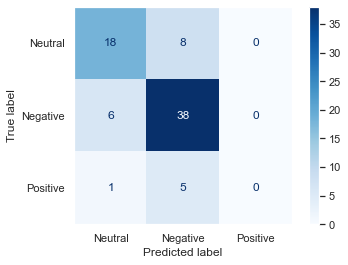

In [153]:
disp.plot(cmap='Blues',ax=None)
plt.grid(False)
plt.show()